# Module 8 - Functional analysis

This notebook will demonstrate how one can perform functional analysis using `R`. This type of analysis is very useful to help interpret long gene lists and make biological sense of them.

In this lesson, the main package we will be using is called [clusterProfiler](https://www.bioconductor.org/packages//release/bioc/html/clusterProfiler.html). This package provides many useful functions to perform different types of functional analysis using different pathway databases.

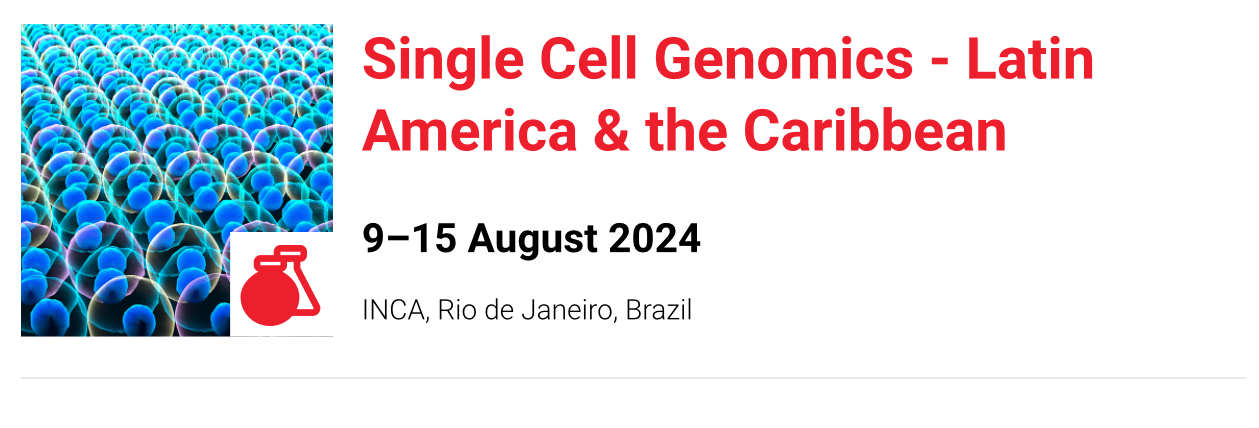

## Pre-analysis steps...

### Install & load required packages

In [1]:
download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_jammy.sh",
              "add_cranapt_jammy.sh")
Sys.chmod("add_cranapt_jammy.sh", "0755")
system("./add_cranapt_jammy.sh")
bspm::enable()
options(bspm.version.check=FALSE)

Tracing function "install.packages" in package "utils"



In [2]:
install.packages(c("ggplot2", "RColorBrewer", "dplyr", "readr"))
install.packages("BiocManager")
BiocManager::install(c("clusterProfiler", "org.Hs.eg.db", "ReactomePA"))


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Installing package(s) 'BiocVersion', 'clusterProfiler', 'org.Hs.eg.db',
  'ReactomePA'

Old packages: 'cluster', 'lubridate', 'testthat'



In [3]:
library(clusterProfiler)
library(org.Hs.eg.db)
library(ggplot2)
library(enrichplot)
library(RColorBrewer)
library(readr)
library(ReactomePA)



clusterProfiler v4.14.4 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

S Xu, E Hu, Y Cai, Z Xie, X Luo, L Zhan, W Tang, Q Wang, B Liu, R Wang,
W Xie, T Wu, L Xie, G Yu. Using clusterProfiler to characterize
multiomics data. Nature Protocols. 2024, doi:10.1038/s41596-024-01020-z


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, r

### Load gene list

In [4]:
markers <- readr::read_csv("https://github.com/benilton/wcs-rio/raw/main/degs_c2xc0.csv.gz")
markers |> head()

Rows: 11365 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): gene
dbl (5): p_val, avg_log2FC, pct.1, pct.2, p_val_adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gene,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MCEMP1,1.072880e-211,3.318062,0.995,0.450,2.174835e-207
APOBEC3A,1.468758e-157,-2.639866,0.685,0.980,2.977319e-153
ALOX5AP,1.438805e-141,1.192886,0.997,0.971,2.916603e-137
IFITM1,1.713684e-139,-2.240540,0.755,0.971,3.473810e-135
LILRB4,1.547143e-126,-1.998057,0.668,0.930,3.136214e-122
HP,2.454568e-126,2.853578,0.881,0.425,4.975655e-122


### Prepare data

The first thing we need to do is prepare our gene list for functional analysis. We will be doing two different types of analysis - over-representation analysis (ORA) and gene set enrichment analysis (GSEA) - and the input data varies a little bit for each.

For ORA, we will need to pre-filter our gene list. We can use log fold change and adjusted p-value as filtering criteria, therefore we will need to set thresholds for them. It is very common to use the following cut-offs:

* `adjusted p-value` $\leq$ `0.05`
* `|log fold change|` $\geq$ `2`

We will need to split our gene list into 3 categories:

*   `both`: this category will include both upregulated and downregulated genes (i.e. `adjusted p-value` $\leq$ `0.05` and `|log fold change|` $\geq$ `2`)
*   `upregulated`: only upregulated genes (i.e. `adjusted p-value` $\leq$ `0.05` and `log fold change` $\geq$ `2`)
*   `downregulated`: only downregulated genes (i.e. `adjusted p-value` $\leq$ `0.05` and `log fold change` $\leq$ `-2`)



In [5]:
my_genes_for_ora <- list(
  "both" = markers$gene[markers$p_val_adj <= 0.05 & abs(markers$avg_log2FC) >= 2],
  "upregulated" = markers$gene[markers$p_val_adj <= 0.05 & markers$avg_log2FC >= 2],
  "downregulated" = markers$gene[markers$p_val_adj <= 0.05 & markers$avg_log2FC <= -2]
)

In [6]:
my_genes_for_ora

$both
  [1] "MCEMP1"     "APOBEC3A"   "IFITM1"     "HP"         "STAC"      
  [6] "MARCKS"     "CXCL11"     "RETN"       "INHBA"      "GPD1"      
 [11] "CCL3"       "PLAC8"      "IL4I1"      "CD36"       "AIM2"      
 [16] "ARHGEF28"   "ITIH5"      "LINC00996"  "FOLR3"      "SMPDL3A"   
 [21] "LGMN"       "MYB"        "C15orf48"   "MGAT3"      "RGL1"      
 [26] "SLC19A3"    "PLTP"       "CMKLR1"     "THBS1"      "LGALS2"    
 [31] "SLAMF7"     "AOC3"       "C1orf54"    "AKAP5"      "TNFAIP6"   
 [36] "CD48"       "IRS2"       "CCL8"       "SDS"        "CCL4"      
 [41] "ECSCR"      "SLC39A8"    "CXCL9"      "ANKRD22"    "DNAAF1"    
 [46] "SDC3"       "NFE2"       "IGFBP4"     "ACOD1"      "TLCD2"     
 [51] "ENPP2"      "RARRES1"    "CCL3L1"     "PDGFD"      "OTOA"      
 [56] "LINC01645"  "SOCS2"      "TIMD4"      "C8B"        "TNIP3"     
 [61] "TMEM171"    "GPR84"      "A2M"        "OVCH1"      "C1S"       
 [66] "AC008763.3" "CCL4L2"     "PLA2G7"     "JAK3"       "SERPINB9"  
 [71] "ZNF365"     "SPHK1"      "IDO1"       "TRGC1"      "TMEM37"    
 [76] "ADORA1"     "FAM20A"     "RAMP2"      "RBP1"       "GAL3ST4"   
 [81] "ANGPT4"     "HAPLN3"     "SLC38A5"    "FADS2"      "LINC01358" 
 [86] "EDN1"       "HAMP"       "IL32"       "THBD"       "SYTL1"     
 [91] "CAVIN4"     "PDGFRL"     "CCL5"       "UBD"        "BCL2L14"   
 [96] "TENT5C"     "KCNJ5"      "DDIT4"      "CRYBB1"     "TMEM156"   
[101] "FMN1"       "SCIN"       "HS3ST1"     "IGF1"       "CD3G"      
[106] "AC243960.1" "FXYD2"      "S100P"      "CEACAM8"    "STON1"     
[111] "FCGR2B"     "MYO7A"      "CD244"      "FAM83G"     "CSPG4"     
[116] "CELA2B"     "CHRM3"      "OLFML2B"    "NALCN"      "LIMD2"     
[121] "AC084030.1" "CCL19"      "CCL20"      "LINC00656"  "AL161740.1"
[126] "CELA1"      "TNFSF8"    

$upregulated
 [1] "MCEMP1"     "HP"         "STAC"       "RETN"       "INHBA"     
 [6] "GPD1"       "PLAC8"      "ARHGEF28"   "ITIH5"      "LINC00996" 
[11] "FOLR3"      "MYB"        "MGAT3"      "SLC19A3"    "THBS1"     
[16] "AOC3"       "AKAP5"      "IRS2"       "ECSCR"      "NFE2"      
[21] "TLCD2"      "PDGFD"      "LINC01645"  "SOCS2"      "C8B"       
[26] "OVCH1"      "AC008763.3" "ZNF365"     "TRGC1"      "ADORA1"    
[31] "ANGPT4"     "FADS2"      "THBD"       "SYTL1"      "CAVIN4"    
[36] "TENT5C"     "DDIT4"      "IGF1"       "CD3G"       "AC243960.1"
[41] "S100P"      "CEACAM8"    "STON1"      "FAM83G"     "CSPG4"     
[46] "CELA2B"     "CHRM3"      "NALCN"      "AC084030.1" "LINC00656" 
[51] "AL161740.1"

$downregulated
 [1] "APOBEC3A"  "IFITM1"    "MARCKS"    "CXCL11"    "CCL3"      "IL4I1"    
 [7] "CD36"      "AIM2"      "SMPDL3A"   "LGMN"      "C15orf48"  "RGL1"     
[13] "PLTP"      "CMKLR1"    "LGALS2"    "SLAMF7"    "C1orf54"   "TNFAIP6"  
[19] "CD48"      "CCL8"      "SDS"       "CCL4"      "SLC39A8"   "CXCL9"    
[25] "ANKRD22"   "DNAAF1"    "SDC3"      "IGFBP4"    "ACOD1"     "ENPP2"    
[31] "RARRES1"   "CCL3L1"    "OTOA"      "TIMD4"     "TNIP3"     "TMEM171"  
[37] "GPR84"     "A2M"       "C1S"       "CCL4L2"    "PLA2G7"    "JAK3"     
[43] "SERPINB9"  "SPHK1"     "IDO1"      "TMEM37"    "FAM20A"    "RAMP2"    
[49] "RBP1"      "GAL3ST4"   "HAPLN3"    "SLC38A5"   "LINC01358" "EDN1"     
[55] "HAMP"      "IL32"      "PDGFRL"    "CCL5"      "UBD"       "BCL2L14"  
[61] "KCNJ5"     "CRYBB1"    "TMEM156"   "FMN1"      "SCIN"      "HS3ST1"   
[67] "FXYD2"     "FCGR2B"    "MYO7A"     "CD244"     "OLFML2B"   "LIMD2"    
[73] "CCL19"     "CCL20"     "CELA1"     "TNFSF8"

For GSEA, we don't need to filter our gene list according to `log fold change`; the only filtering we will do is by `adjusted p-value`!

In [7]:
my_genes_for_gsea <- markers$avg_log2FC[markers$p_val_adj <= 0.05]
names(my_genes_for_gsea) <- markers$gene[markers$p_val_adj <= 0.05]
my_genes_for_gsea <- sort(my_genes_for_gsea, decreasing = TRUE)

In [8]:
my_genes_for_gsea

ECSCR   AC084030.1      CEACAM8         GPD1    LINC00656       MCEMP1 
   3.7835694    3.6918413    3.6350864    3.6270842    3.4530685    3.3180617 
      ANGPT4   AC008763.3          MYB    LINC00996      SLC19A3        NALCN 
   3.1830317    3.1571990    3.1360643    3.0492981    3.0450890    2.9673249 
        NFE2        THBS1       CAVIN4           HP         IGF1        CSPG4 
   2.9340008    2.9138621    2.8829103    2.8535780    2.8470001    2.7504284 
       SYTL1        INHBA       CELA2B        PDGFD          C8B         CD3G 
   2.7397704    2.6605318    2.5922768    2.5808874    2.5796357    2.5773728 
       STON1         STAC       TENT5C       ZNF365        ITIH5       FAM83G 
   2.5584194    2.5525166    2.5301170    2.4260630    2.4232773    2.4193989 
       TRGC1        FADS2        FOLR3        DDIT4        OVCH1    LINC01645 
   2.4114941    2.4102084    2.3559786    2.3486897    2.3307741    2.2436623 
       PLAC8   AC243960.1         AOC3   AL161740.1        MGAT3        SOCS2 
   2.2252728    2.2240082    2.1749437    2.1682681    2.1540381    2.1538314 
       CHRM3        TLCD2        S100P         RETN        AKAP5       ADORA1 
   2.1306660    2.1234894    2.1207551    2.1097226    2.0943659    2.0769952 
        THBD         IRS2     ARHGEF28        CLCF1     TBC1D10C         SVIL 
   2.0183141    2.0127352    2.0102001    1.9873653    1.9668963    1.9575443 
        AQP3        ANXA3   AC069185.1        DDIAS          CD6   AJ009632.2 
   1.9416895    1.9370772    1.9345764    1.9257270    1.9237174    1.9218687 
        KSR1        SUSD3        TRGC2          ID3        HCAR2        DHCR7 
   1.9108914    1.9002693    1.8775854    1.8690617    1.8688028    1.8654099 
       FFAR4         RGCC         AGRP      TMEM236   AC004918.1   AC068594.1 
   1.8590505    1.8531907    1.8442276    1.8111162    1.8092672    1.7980224 
     ZDHHC19       PNPLA6        HBEGF        CD101      COLEC12        SMAD7 
   1.7411666    1.7411486    1.7360307    1.7331183    1.7156326    1.6987052 
      MALRD1          ID2        FRAT2   AL034397.3      LRRC75A         NET1 
   1.6883134    1.6867143    1.6814607    1.6511950    1.6438111    1.6374792 
        JAG1     KIAA1147        APOBR         LDLR       FGFRL1       SLC1A7 
   1.6237685    1.6135064    1.6129826    1.6127142    1.5917092    1.5908907 
       LSAMP         MRC1       FAM89A   AL365361.1        HMGCR         FBN1 
   1.5872048    1.5774633    1.5536672    1.5461074    1.5454134    1.5430183 
     TMEM74B       AKR1C2          ACE   AC119396.1       MOGAT1   AL138828.1 
   1.5279383    1.5226595    1.5116970    1.5097367    1.5012738    1.4992644 
       CEBPA        ZFP92        DGAT2        SNAI3         CD52       AMIGO2 
   1.4984153    1.4957483    1.4955993    1.4918718    1.4844263    1.4819429 
      GPR153       ARRDC4         SQLE        LPAR3     SIGLEC12        TSEN2 
   1.4739498    1.4733180    1.4705194    1.4703613    1.4695080    1.4671916 
      SH2D3C       ODF3L1   AC009093.2    RAB11FIP4         RARA       FLVCR1 
   1.4665575    1.4602905    1.4582984    1.4373851    1.4262396    1.4259791 
         LAT         LFNG          LPL       ZNF589         KAZN        FRAT1 
   1.4156861    1.4140791    1.4137980    1.4081427    1.4048856    1.4013249 
     TMEM104        NEIL2       PTGER3   AC083949.1        PPARG      PCOLCE2 
   1.3990419    1.3928309    1.3897541    1.3876022    1.3815113    1.3777040 
       ACKR3      BHLHE40         DTX4         DVL1        WDR49       PLXNA2 
   1.3692453    1.3678960    1.3572551    1.3515596    1.3514974    1.3498144 
       MSMO1          SKI      PLEKHB1       RHBDD2         FHL1       ATP10A 
   1.3452399    1.3437639    1.3435439    1.3419966    1.3415152    1.3382997 
    ADAMTSL4         SOX4      CYSLTR1      ARHGEF5        CEBPB      SLC24A4 
   1.3296274    1.3276786    1.3247346    1.3217887    1.3206000    1.3167096 
     CCDC170        S1PR4     SLC39A10      KAZALD1      

### Creating some plotting functions

#### ORA bar plot

In [10]:
make_ora_barplot <- function(ora_results, n_terms, db, title) {

  ora_results_filt <- ora_results[order(ora_results$p.adjust, decreasing = FALSE), ] %>% head(n_terms)

  ggplot(ora_results_filt, aes(x = Count, y = reorder(Description, Count), fill = -log10(p.adjust))) +
    geom_col(color = "black") +
    theme_classic() +
    theme(
      axis.text = element_text(size = 8),
      axis.title = element_text(size = 12),
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5)
    ) +
    xlab("Gene count") +
    ylab(paste0(db, " term")) +
    scale_fill_gradientn(
      colors = colorRampPalette(brewer.pal(9, "Reds"))(100),
      name = expression("-log"[10]~"(Adjusted p-value)")
    ) +
    ggtitle(title)

}

#### ORA dot plot

In [11]:
make_ora_dotplot <- function(ora_results, n_terms, db, title) {

  ora_results_filt <- ora_results[order(ora_results$p.adjust, decreasing = FALSE), ] %>% head(n_terms)

  ggplot(ora_results_filt, aes(x = Count, y = reorder(Description, Count), fill = -log10(p.adjust))) +
    geom_point(size = 5, alpha = 0.8, shape = 21, color = "black") +
    theme_bw() +
    theme(
      axis.text = element_text(size = 8),
      axis.title = element_text(size = 12),
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5)
    ) +
    xlab("Gene count") +
    ylab(paste0(db, " term")) +
    scale_fill_gradientn(
      colors = colorRampPalette(brewer.pal(9, "Reds"))(100),
      name = expression("-log"[10]~"(Adjusted p-value)")
    ) +
    ggtitle(title)

}

#### GSEA bar plot

In [13]:
make_gsea_barplot <- function(gsea_results, n_terms, db, title) {

  gsea_results_sorted <- gsea_results[order(gsea_results$NES, decreasing = TRUE), ]
  gsea_results_filt <- rbind(head(gsea_results_sorted, n_terms), tail(gsea_results_sorted, n_terms))

  ggplot(gsea_results_filt, aes(x = NES, y = reorder(Description, NES), fill = -log10(p.adjust))) +
    geom_col(color = "black") +
    theme_classic() +
    theme(
      axis.text = element_text(size = 8),
      axis.title = element_text(size = 12),
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5)
    ) +
    xlab("Normalised enrichment score") +
    ylab(paste0(db, " term")) +
    scale_fill_gradientn(
      colors = colorRampPalette(brewer.pal(9, "Reds"))(100),
      name = expression("-log"[10]~"(Adjusted p-value)")
    ) +
    ggtitle(title)

}

## Part I - Over-representation analysis (ORA)

In today's lesson, we will be doing ORA with the [Gene Ontology (GO)](https://geneontology.org/) and [Kyoto Encyclopedia of Genes and Genomes (KEGG)](https://www.genome.jp/kegg/:) databases.

The ORA logic is pretty much the same regardless of the database you use. The main difference will be that, to do ORA using different databases, we will need to use different functions from the package `clusterProfiler`.

### Gene Ontology (GO)

#### GO - Both up and downregulated genes

Let's start by performing ORA on all genes of interest, stored at `my_genes_for_ora$both`. Note that `my_genes_for_ora$both` contains both upregulated and downregulated genes.

In [14]:
go_ora_both <- enrichGO(
  gene = my_genes_for_ora$both,
  OrgDb = org.Hs.eg.db,
  ont = "ALL",
  keyType = "SYMBOL",
  pvalueCutoff = 0.05
)

We can check what `go_ora_both` looks like:

In [15]:
go_ora_both

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 GOALL 
#...@keytype 	 SYMBOL 
#...@gene 	 chr [1:127] "MCEMP1" "APOBEC3A" "IFITM1" "HP" "STAC" "MARCKS" "CXCL11" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...324 enriched terms found
'data.frame':	324 obs. of  13 variables:
 $ ONTOLOGY      : chr  "BP" "BP" "BP" "BP" ...
 $ ID            : chr  "GO:0070098" "GO:0097529" "GO:0071621" "GO:1990868" ...
 $ Description   : chr  "chemokine-mediated signaling pathway" "myeloid leukocyte migration" "granulocyte chemotaxis" "response to chemokine" ...
 $ GeneRatio     : chr  "11/113" "15/113" "12/113" "11/113" ...
 $ BgRatio       : chr  "93/18986" "243/18986" "129/18986" "102/18986" ...
 $ RichFactor    : num  0.1183 0.0617 0.093 0.1078 0.1078 ...
 $ FoldEnrichment: num  19.9 10.4 15.6 18.1 18.1 ...
 $ zScore        : num  14.1 11.4 12.9 13.4 13.4 ...
 $ pvalue        : num  8.19e-12 1.56e-11 1.59e-11 2.29e-11 2.29e-11 ...
 $ p.adjust      : num  1.19e-08 1

We can plot the results using the functions `make_ora_barplot` and `make_ora_dotplot`, which we created above. Note that you can access the ORA results in the slot `result` of the `enrichResults` object generated by the function `enrichGO()`, as in `go_ora_both@result`.

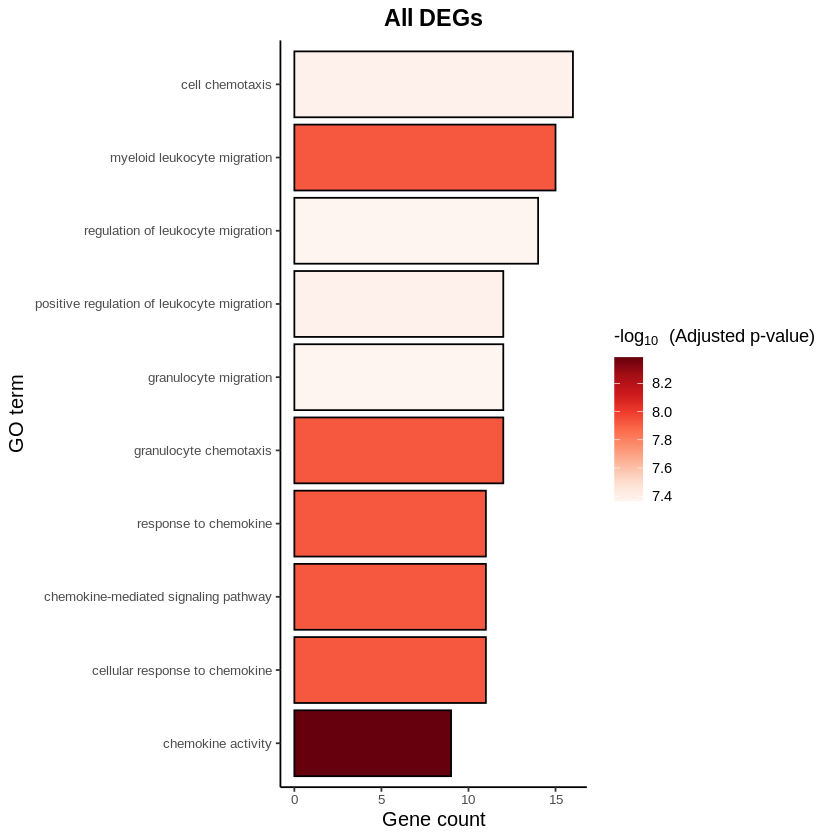

In [16]:
make_ora_barplot(ora_results = go_ora_both@result, n_terms = 10, db = "GO", title = "All DEGs")

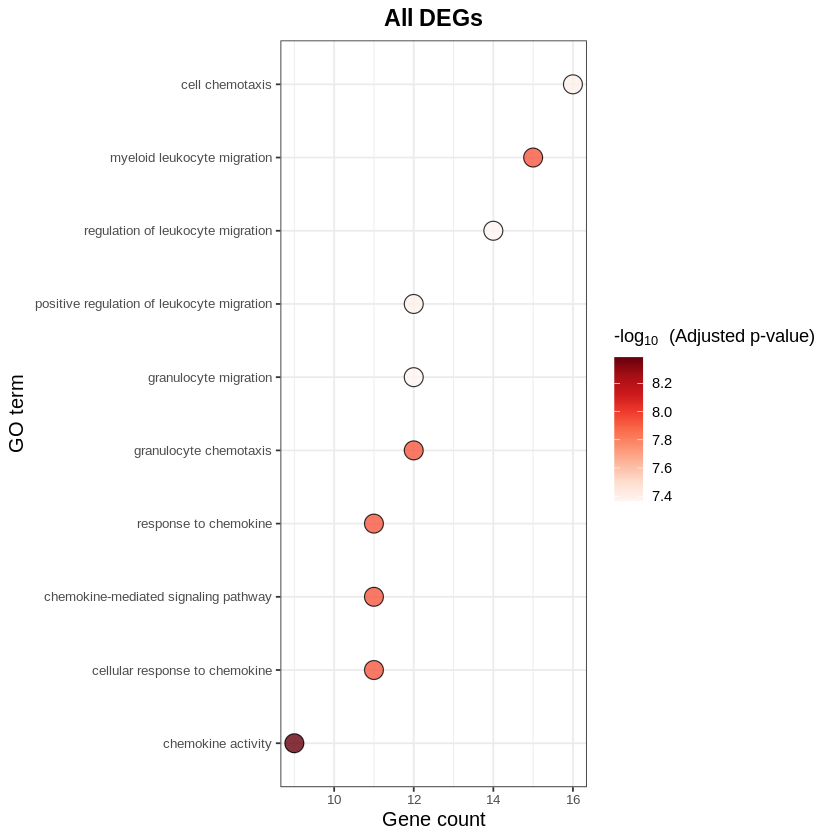

In [17]:
make_ora_dotplot(ora_results = go_ora_both@result, n_terms = 10, db = "GO", title = "All DEGs")

When we do ORA on a gene list containing both up and downregulated genes, it is not straightforward to look at the results and know if a given process or pathway is enriched in the up or downregulated genes. We can therefore perform ORA twice, on two separate gene lists.

We will now be using the genes stored at `my_genes_for_ora$upregulated` and `my_genes_for_ora$downregulated`.

#### GO - Only upregulated genes

First, let's use the list of upregulated genes and find out which GO terms are enriched there:

In [18]:
go_ora_up <- enrichGO(
  gene = my_genes_for_ora$upregulated,
  OrgDb = org.Hs.eg.db,
  ont = "ALL",
  keyType = "SYMBOL"
)

In [19]:
go_ora_up

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 GOALL 
#...@keytype 	 SYMBOL 
#...@gene 	 chr [1:51] "MCEMP1" "HP" "STAC" "RETN" "INHBA" "GPD1" "PLAC8" "ARHGEF28" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...125 enriched terms found
'data.frame':	125 obs. of  13 variables:
 $ ONTOLOGY      : chr  "BP" "BP" "BP" "BP" ...
 $ ID            : chr  "GO:0051047" "GO:0046887" "GO:0032891" "GO:0046883" ...
 $ Description   : chr  "positive regulation of secretion" "positive regulation of hormone secretion" "negative regulation of organic acid transport" "regulation of hormone secretion" ...
 $ GeneRatio     : chr  "7/43" "5/43" "3/43" "6/43" ...
 $ BgRatio       : chr  "322/18986" "147/18986" "24/18986" "261/18986" ...
 $ RichFactor    : num  0.0217 0.034 0.125 0.023 0.0284 ...
 $ FoldEnrichment: num  9.6 15 55.2 10.2 12.5 ...
 $ zScore        : num  7.41 8.13 12.66 7.09 7.33 ...
 $ pvalue        : num  7.21e-06 1.97e-05 2.12e-05 2.54e-05 4.68e-05 ...
 $

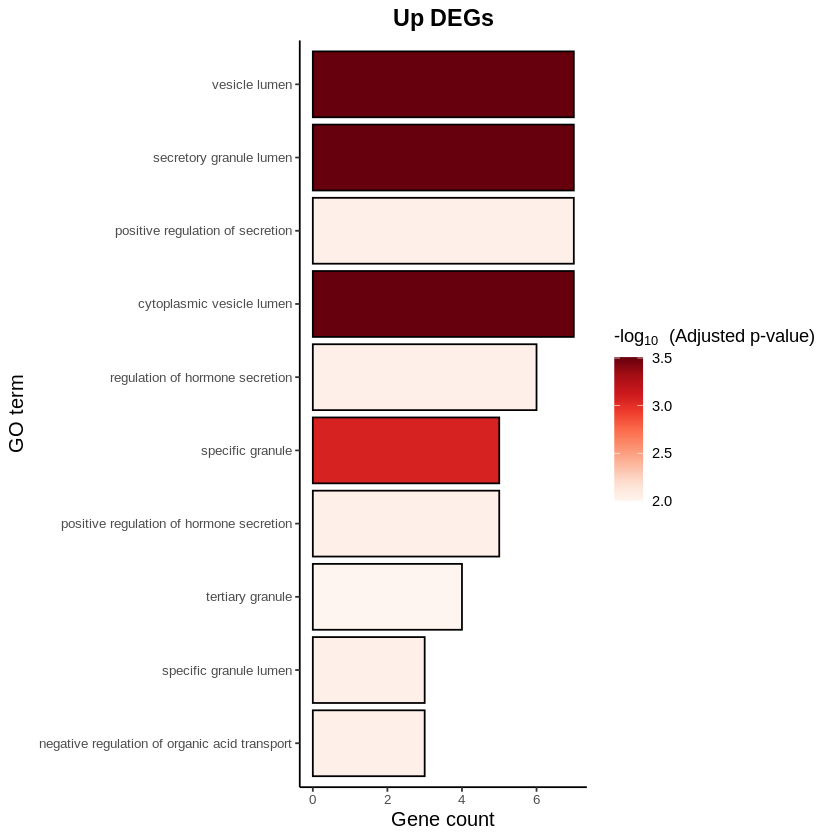

In [20]:
make_ora_barplot(ora_results = go_ora_up@result, n_terms = 10, db = "GO", title = "Up DEGs")

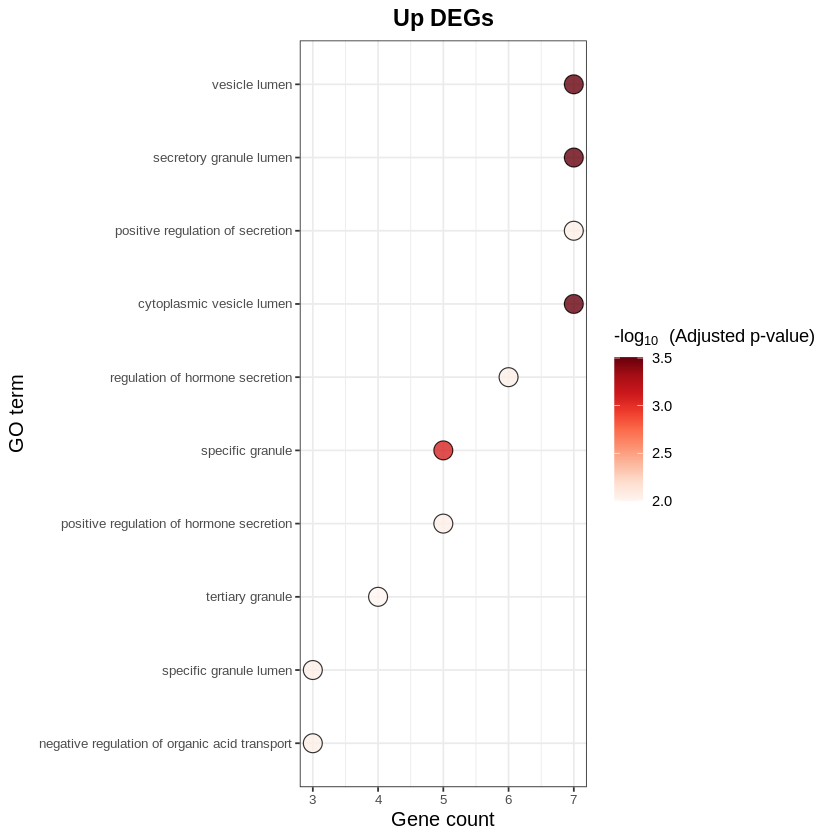

In [21]:
make_ora_dotplot(ora_results = go_ora_up@result, n_terms = 10, db = "GO", title = "Up DEGs")

#### GO - Only downregulated genes

Now let's do the same with the list of downregulated genes:

In [22]:
go_ora_down <- enrichGO(
  gene = my_genes_for_ora$downregulated,
  OrgDb = org.Hs.eg.db,
  ont = "ALL",
  keyType = "SYMBOL"
)

In [23]:
go_ora_down

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 GOALL 
#...@keytype 	 SYMBOL 
#...@gene 	 chr [1:76] "APOBEC3A" "IFITM1" "MARCKS" "CXCL11" "CCL3" "IL4I1" "CD36" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...249 enriched terms found
'data.frame':	249 obs. of  13 variables:
 $ ONTOLOGY      : chr  "BP" "BP" "BP" "BP" ...
 $ ID            : chr  "GO:0070098" "GO:1990868" "GO:1990869" "GO:0071621" ...
 $ Description   : chr  "chemokine-mediated signaling pathway" "response to chemokine" "cellular response to chemokine" "granulocyte chemotaxis" ...
 $ GeneRatio     : chr  "11/70" "11/70" "11/70" "11/70" ...
 $ BgRatio       : chr  "93/18986" "102/18986" "102/18986" "129/18986" ...
 $ RichFactor    : num  0.1183 0.1078 0.1078 0.0853 0.0542 ...
 $ FoldEnrichment: num  32.1 29.3 29.3 23.1 14.7 ...
 $ zScore        : num  18.3 17.4 17.4 15.3 13 ...
 $ pvalue        : num  3.62e-14 1.03e-13 1.03e-13 1.42e-12 3.81e-12 ...
 $ p.adjust      : num  6.71e-11 6.7

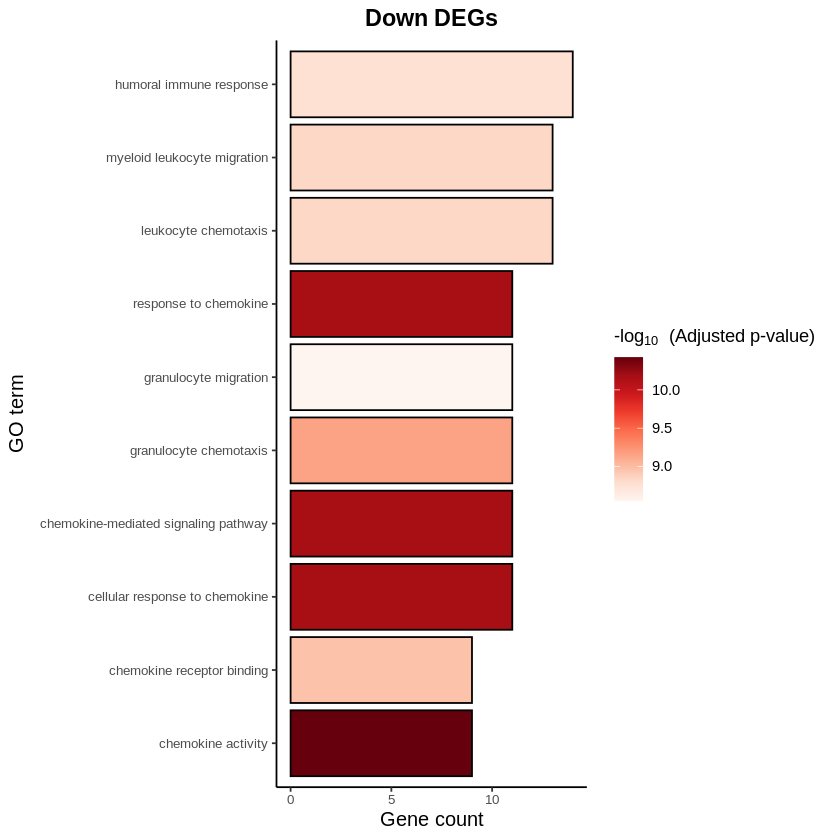

In [24]:
make_ora_barplot(ora_results = go_ora_down@result, n_terms = 10, db = "GO", title = "Down DEGs")

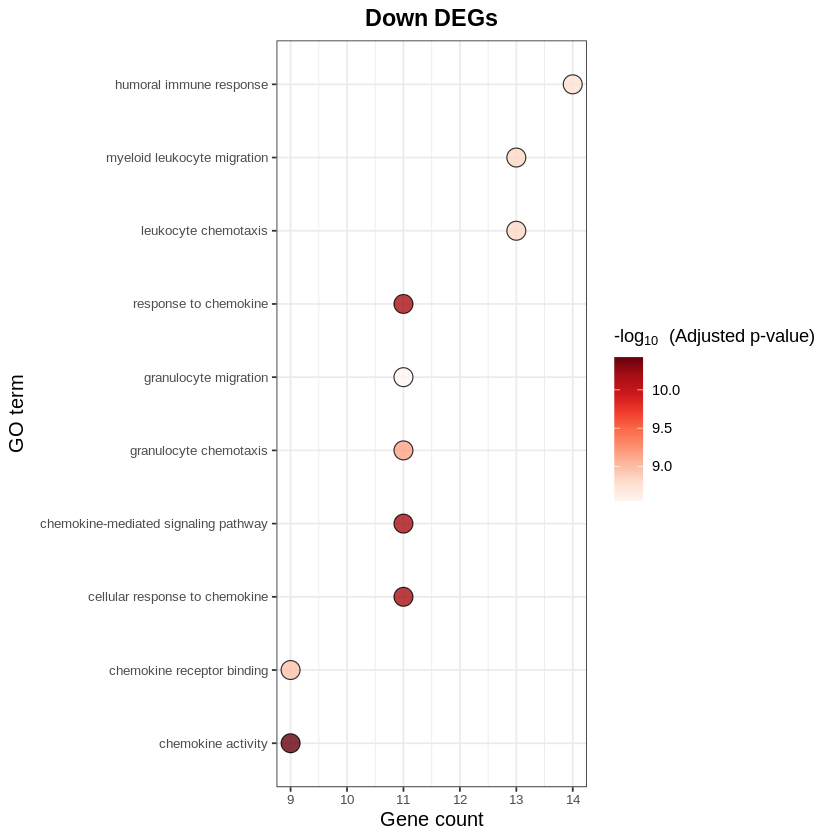

In [25]:
make_ora_dotplot(ora_results = go_ora_down@result, n_terms = 10, db = "GO", title = "Down DEGs")

### Kyoto Encyclopedia of Genes and Genomes (KEGG)

We have just studied how to perform ORA using the GO database. Now we will use a different database, KEGG.

When we used GO, the `clusterProfiler` function we needed for ORA was called `enrichGO()`. ORA with KEGG, on the other hand, will require the function `enrichKEGG()`.

The `enrichKEGG()` function will require ENTREZ gene IDs, and we currently have only gene symbols. The convertion between IDs can be easily done using the `bitr()` function.

To facilitate our work, we will define a function that will take a gene list as input and then do the following steps:


1.   Convert gene symbols to ENTREZ IDs using `bitr()`
2.   Run ORA using `enrichKEGG()`
3.   Return the ORA results



In [26]:
run_ora_with_kegg <- function(gene_list) {

  cat("Converting gene IDs...\n\n")

  converted_ids <- bitr(
    geneID = gene_list,
    fromType = "SYMBOL",
    toType = "ENTREZID",
    OrgDb = org.Hs.eg.db
  )

  cat("\nPerforming ORA with KEGG...\n\n")

  kegg_ora <- enrichKEGG(
    gene = converted_ids$ENTREZID,
    organism = "hsa",
    pvalueCutoff = 0.05
  )

  cat("Done!\n\n")

  return(kegg_ora)

}

Now that we have the function `run_ora_with_kegg()`, we can easily perform the ID conversion followed by ORA on all the gene lists we stored at `my_genes_for_ora`!

#### KEGG - Both up and downregulated genes

In [27]:
kegg_ora_both <- run_ora_with_kegg(gene_list = my_genes_for_ora$both)

Converting gene IDs...



'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(geneID = gene_list, fromType = "SYMBOL", toType = "ENTREZID", :
“3.15% of input gene IDs are fail to map...”



Performing ORA with KEGG...



Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



Done!



In [28]:
kegg_ora_both

#
# over-representation test
#
#...@organism 	 hsa 
#...@ontology 	 KEGG 
#...@keytype 	 kegg 
#...@gene 	 chr [1:123] "199675" "200315" "8519" "3240" "6769" "4082" "6373" "56729" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...4 enriched terms found
'data.frame':	4 obs. of  14 variables:
 $ category      : chr  "Environmental Information Processing" "Organismal Systems" "Environmental Information Processing" "Organismal Systems"
 $ subcategory   : chr  "Signaling molecules and interaction" "Immune system" "Signaling molecules and interaction" "Immune system"
 $ ID            : chr  "hsa04061" "hsa04062" "hsa04060" "hsa04620"
 $ Description   : chr  "Viral protein interaction with cytokine and cytokine receptor" "Chemokine signaling pathway" "Cytokine-cytokine receptor interaction" "Toll-like receptor signaling pathway"
 $ GeneRatio     : chr  "10/68" "11/68" "13/68" "7/68"
 $ BgRatio       : chr  "100/8876" "193/8876" "298/8876" "109/8876"
 $ RichFactor    : num  0.1 0.057 0.0

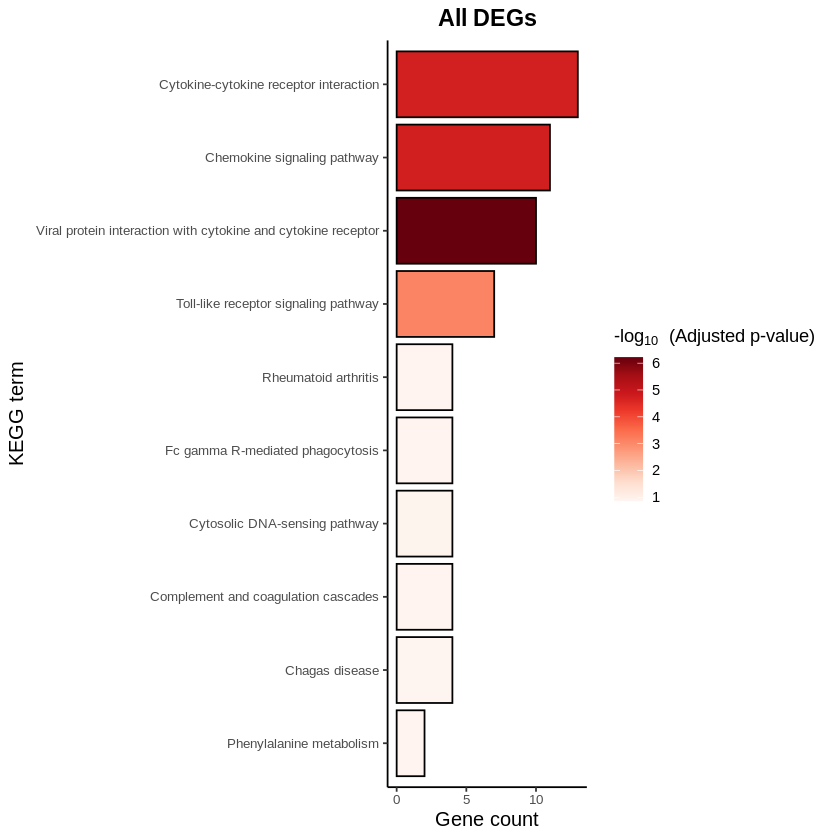

In [29]:
make_ora_barplot(ora_results = kegg_ora_both@result, n_terms = 10, db = "KEGG", title = "All DEGs")

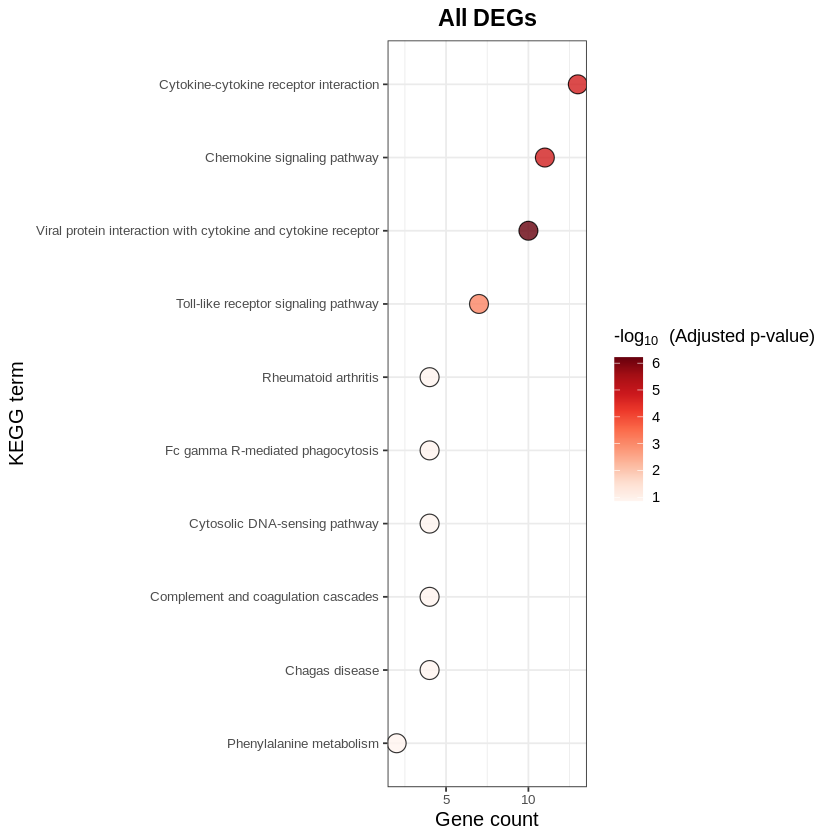

In [30]:
make_ora_dotplot(ora_results = kegg_ora_both@result, n_terms = 10, db = "KEGG", title = "All DEGs")

#### KEGG - Only upregulated genes

In [31]:
kegg_ora_up <- run_ora_with_kegg(gene_list = my_genes_for_ora$upregulated)

Converting gene IDs...



'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(geneID = gene_list, fromType = "SYMBOL", toType = "ENTREZID", :
“7.84% of input gene IDs are fail to map...”



Performing ORA with KEGG...

Done!



In [32]:
kegg_ora_up

#
# over-representation test
#
#...@organism 	 hsa 
#...@ontology 	 KEGG 
#...@keytype 	 kegg 
#...@gene 	 chr [1:47] "199675" "3240" "6769" "56729" "3624" "2819" "51316" "64283" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...1 enriched terms found
'data.frame':	1 obs. of  14 variables:
 $ category      : chr "Environmental Information Processing"
 $ subcategory   : chr "Signal transduction"
 $ ID            : chr "hsa04151"
 $ Description   : chr "PI3K-Akt signaling pathway"
 $ GeneRatio     : chr "6/22"
 $ BgRatio       : chr "362/8876"
 $ RichFactor    : num 0.0166
 $ FoldEnrichment: num 6.69
 $ zScore        : num 5.51
 $ pvalue        : num 0.000189
 $ p.adjust      : num 0.0191
 $ qvalue        : num 0.0151
 $ geneID        : chr "4602/7057/80310/51378/54541/3479"
 $ Count         : int 6
#...Citation
S Xu, E Hu, Y Cai, Z Xie, X Luo, L Zhan, W Tang, Q Wang, B Liu, R Wang, W Xie, T Wu, L Xie, G Yu. Using clusterProfiler to characterize multiomics data. Nature Protocols. 2

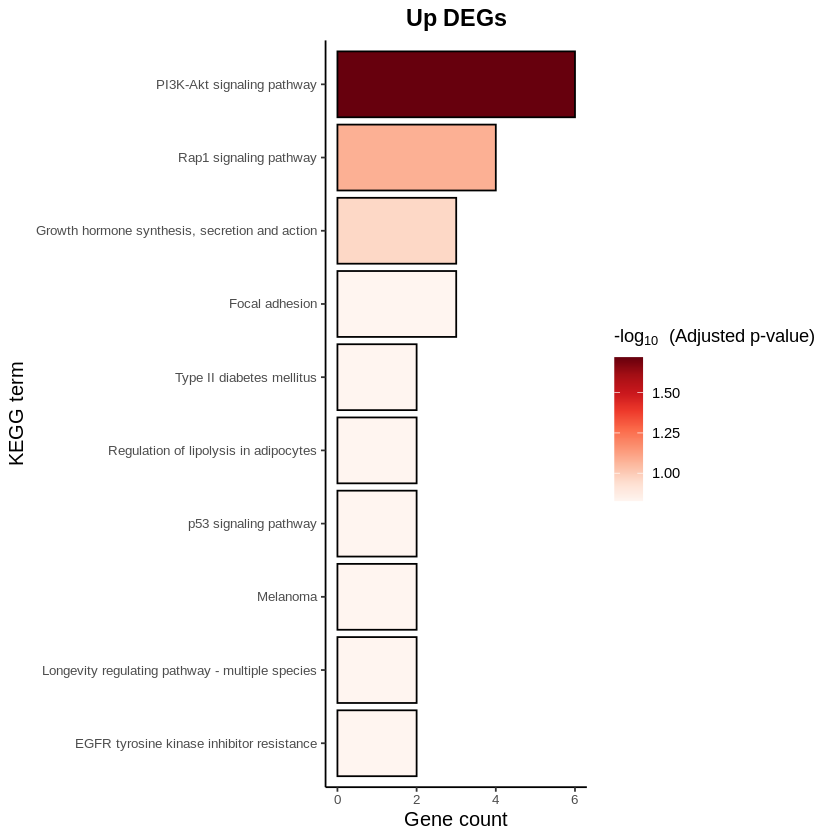

In [33]:
make_ora_barplot(ora_results = kegg_ora_up@result, n_terms = 10, db = "KEGG", title = "Up DEGs")

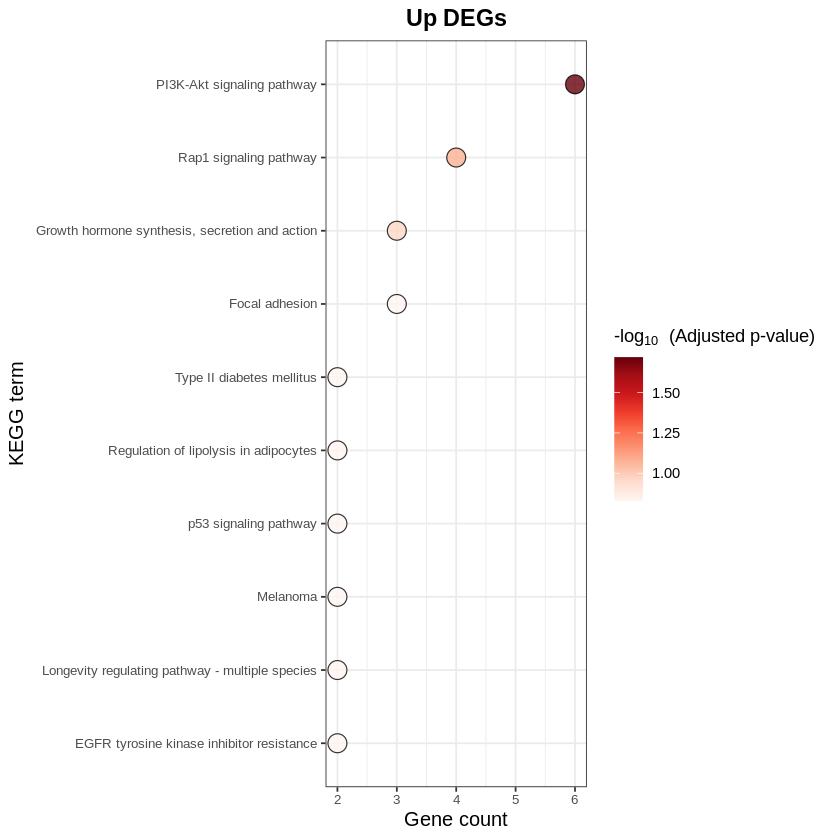

In [34]:
make_ora_dotplot(ora_results = kegg_ora_up@result, n_terms = 10, db = "KEGG", title = "Up DEGs")

#### KEGG - Only downregulated genes

In [35]:
kegg_ora_down <- run_ora_with_kegg(gene_list = my_genes_for_ora$downregulated)

Converting gene IDs...



'select()' returned 1:1 mapping between keys and columns




Performing ORA with KEGG...

Done!



In [36]:
kegg_ora_down

#
# over-representation test
#
#...@organism 	 hsa 
#...@ontology 	 KEGG 
#...@keytype 	 kegg 
#...@gene 	 chr [1:76] "200315" "8519" "4082" "6373" "6348" "259307" "948" "9447" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...7 enriched terms found
'data.frame':	7 obs. of  14 variables:
 $ category      : chr  "Environmental Information Processing" "Organismal Systems" "Environmental Information Processing" "Organismal Systems" ...
 $ subcategory   : chr  "Signaling molecules and interaction" "Immune system" "Signaling molecules and interaction" "Immune system" ...
 $ ID            : chr  "hsa04061" "hsa04062" "hsa04060" "hsa04620" ...
 $ Description   : chr  "Viral protein interaction with cytokine and cytokine receptor" "Chemokine signaling pathway" "Cytokine-cytokine receptor interaction" "Toll-like receptor signaling pathway" ...
 $ GeneRatio     : chr  "10/46" "11/46" "12/46" "7/46" ...
 $ BgRatio       : chr  "100/8876" "193/8876" "298/8876" "109/8876" ...
 $ RichFactor   

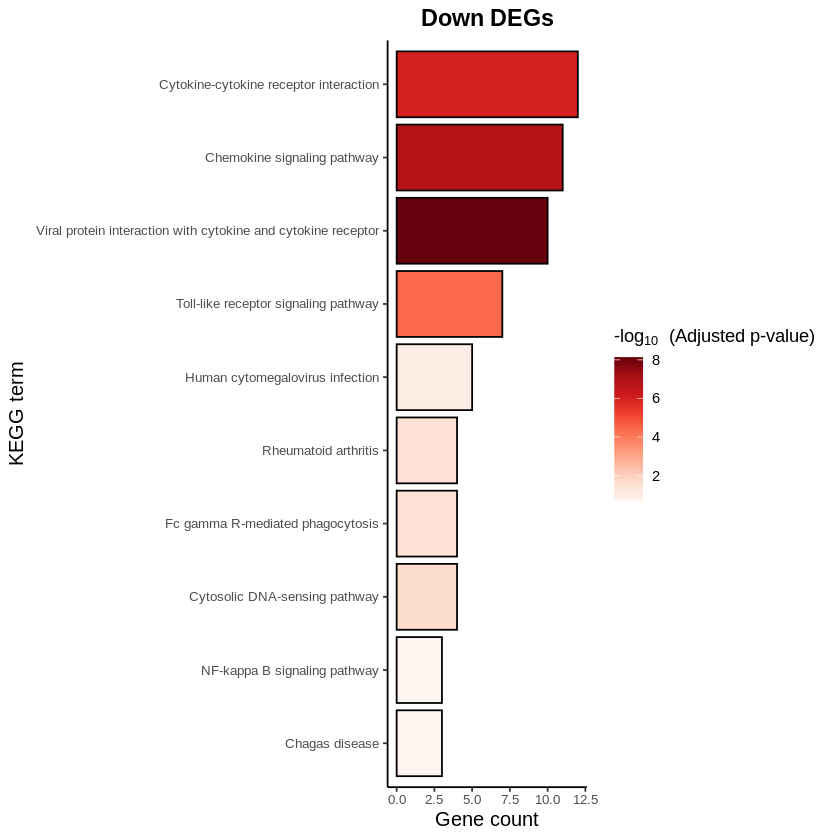

In [37]:
make_ora_barplot(ora_results = kegg_ora_down@result, n_terms = 10, db = "KEGG", title = "Down DEGs")

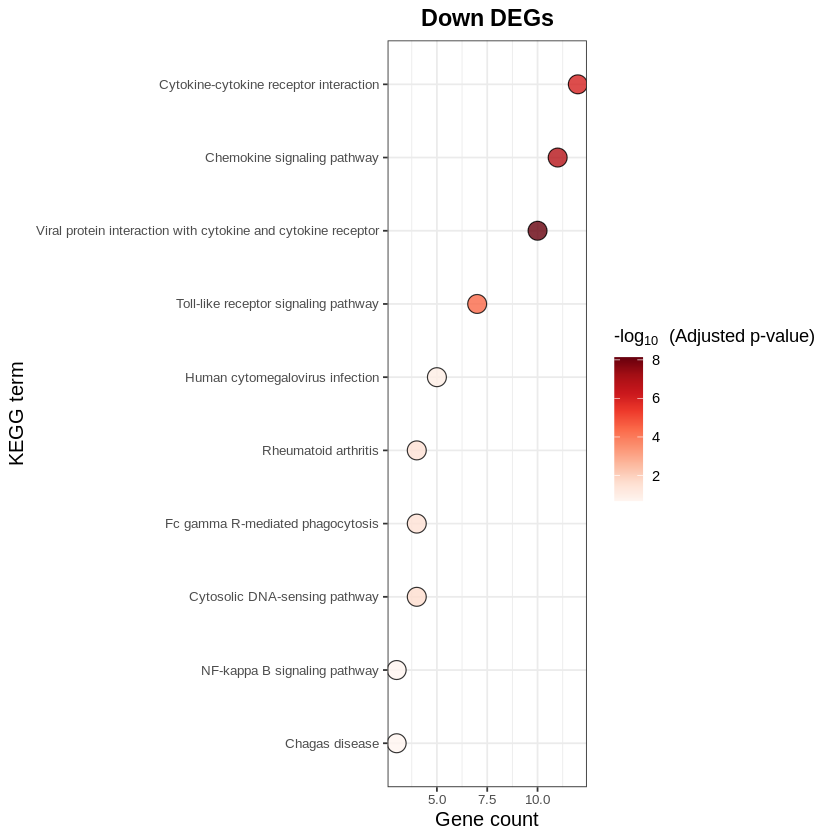

In [38]:
make_ora_dotplot(ora_results = kegg_ora_down@result, n_terms = 10, db = "KEGG", title = "Down DEGs")

## Part II - Gene set enrichment analysis (GSEA)

For GSEA, we will be using the [GO database](https://geneontology.org/).

### GO

In [39]:
go_gsea <- gseGO(
  geneList = my_genes_for_gsea,
  OrgDb = org.Hs.eg.db,
  ont = "ALL",
  pvalueCutoff = 0.05,
  verbose = TRUE,
  keyType = "SYMBOL"
)

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



In [40]:
go_gsea

#
# Gene Set Enrichment Analysis
#
#...@organism 	 Homo sapiens 
#...@setType 	 GOALL 
#...@keytype 	 SYMBOL 
#...@geneList 	 Named num [1:1825] 3.78 3.69 3.64 3.63 3.45 ...
 - attr(*, "names")= chr [1:1825] "ECSCR" "AC084030.1" "CEACAM8" "GPD1" ...
#...nPerm 	 
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...208 enriched terms found
'data.frame':	208 obs. of  12 variables:
 $ ONTOLOGY       : chr  "BP" "BP" "BP" "MF" ...
 $ ID             : chr  "GO:0019730" "GO:0006959" "GO:0061844" "GO:0042379" ...
 $ Description    : chr  "antimicrobial humoral response" "humoral immune response" "antimicrobial humoral immune response mediated by antimicrobial peptide" "chemokine receptor binding" ...
 $ setSize        : int  28 58 23 15 13 238 252 312 307 307 ...
 $ enrichmentScore: num  -0.815 -0.689 -0.842 -0.898 -0.928 ...
 $ NES            : num  -2.76 -2.72 -2.71 -2.66 -2.6 ...
 $ pvalue         : num  1e-10 1e-10 1e-10 1e-10 1e-10 ...
 $ p.adjust       : num  1.84e-08 1.84e-08 1.84e-08 1

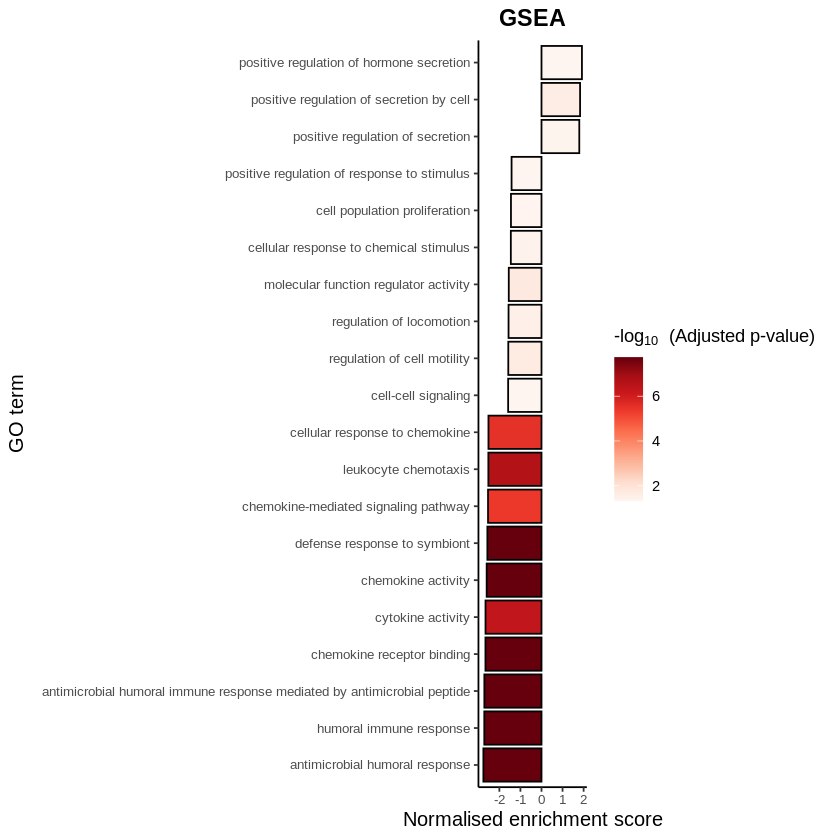

In [41]:
make_gsea_barplot(gsea_results = go_gsea@result, n_terms = 10, db = "GO", title = "GSEA")

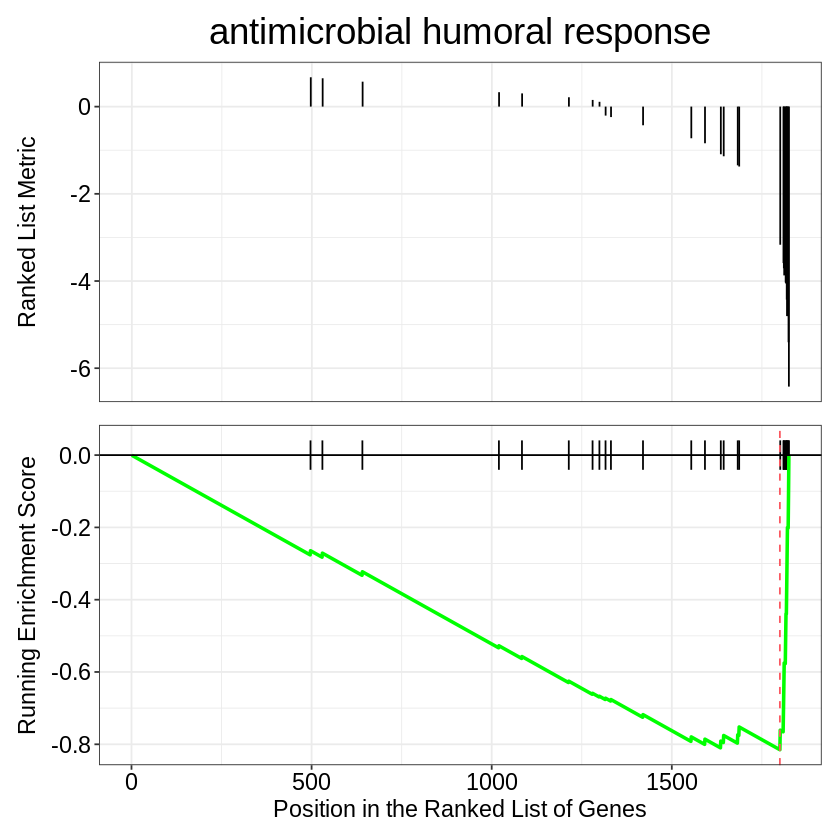

In [42]:
gseaplot(go_gsea, geneSetID = 1, title = go_gsea$Description[1])

## Exercise

Using the genes stored in `my_genes_for_ora`, perform an over-representation analysis using the Reactome database. You can use the code above as a reference, and you can also refer to the `clusterProfiler` documentation [here](http://yulab-smu.top/biomedical-knowledge-mining-book/reactomepa.html). Hint: you can use the function `enrichPathway()`